# Disclaimer: dit is een gevolgde tutorial.
Dit is de tutorial die gevolgd heb, dit is ook de tutorial de aanbevolen werd voor de Mesa opdracht. Deze tutorial heb ik dus in dit bestand meegetypt. De enige eigen aanpassing die ik in dit bestand heb gemaakt is dat de agent 2 wealth geeft als de persoon die hij aanspreekt geen geld heeft (meer hierover in het kopje 'De MoneyAgent class'). Dit wilde ik even voor de zekerheid vermelden, voor als het opeens niet de bedoeling was dat ik deze tutorial overnam terwijl ik de tutorial volgde (voor plagiaat).

# Imports.
De benodigde libraries importeren.

In [1]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import matplotlib.pyplot as plt
from mesa.space import MultiGrid
import numpy as np
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule
from mesa.visualization.ModularVisualization import VisualizationElement

# Gini-coëfficiënt berekenen.
De Gini-coëfficiënt is een manier om ongelijkheid van inkomensverdeling binnen een land te bekijken. De Gini-coëfficiënt neemt altijd een getal tussen de 0 en de 1 aan. Hoe hoger dit getal is, des te ongelijker het land is aangaande inkomensverdeling. Hierin betekent het getal 0 dat het inkomen volkomen gelijk verdeeld is en het getal 1 dat het inkomen volkomen ongelijk verdeeld is.

In [2]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths) # De wealth per agent op een rij gezet van klein naar groot.
    N = model.num_agents # Dit zijn 50 agents in dit geval.
    B = sum(xi * (N-i) for i,xi in enumerate(x)) / (N*sum(x)) # De formule om de Gini-coëfficiënt te berekenen.
    return (1 + (1/N) - 2*B)

# De MoneyAgent class.
Functie 'step': in deze functie check de agent of hij meer dan 0 wealth heeft, als dat het geval is wordt de functie 'move'
aangeroepen, die functie zorgt ervoor dat de agent naar één van de acht naastliggende velden gaat (Ja altijd 8 velden, als je bijvoorbeeld rechts onderin staat en je gaat naar rechts, kom je links onderin in de hoek. Als je daarna naar beneden gaat, kom je links boven in de hoek, etc.). Nadat de agent naar een ander veld is gegaan word de functie 'give_money' aangeroepen. Nadat deze functie is aangeroepen, kijkt de functie of er andere agent(s) op hetzelfde vlak staat. Als dat het geval is kiest die agent een random agent op hetzelfde vlak om wealth aan te geven, als die gekozen persoon 0 wealth heeft krijgt die agent één wealth van de agent en één wealth van de 'game' (Om zo een beetje de echte wereld te simuleren, in de echte wereld krijgen armen namelijk steun van de overheid). Als die agent meer dan 0 wealth heeft krijgt de agent alleen één wealth van de agent die aan de beurd is. Zie het zo voor je: als je een random iemand aanspreekt in een gebouw en vraagt of die persoon geld heeft, als die persoon geld heeft (dus meer dan 0 wealth) krijgt hij één euro. Als de persoon die je random aanspreekt geen geld heeft krijgt hij dus 2 euro, één van jou en één van de overheid. Dit verhaal heb ik geschreven om u een beter beeld te geven bij de situatie. In dit verhaal is het gebouw waarin u zich bevind een veld, geld is wealth en de overheid is de 'game'.

In [3]:
class MoneyAgent(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True, # door deze moore= True, zijn er altijd 8 naastliggende velden.
            include_center=False)
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        other_agent = self.random.choice(cellmates)
        if len(cellmates) > 1:
            if other_agent.wealth == 0:
                other_agent.wealth += 2
                self.wealth -= 1
            else:
                other_agent.wealth += 1
                self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()

# Het MoneyModel class.
In deze code worden de agents en de ruimte waar de agents kunnen 'rondlopen' gemaakt. De gemaakte ruimte is in dit geval een 10 bij 10 vlak met dus 100 velden, daarna wordt elke agent in een random veld gezet. Ook geeft deze functie een random volgorde waarin de agents activeren (aan de beurd zijn).

In [4]:
class MoneyModel(Model):
    def __init__(self, N=100, width=10, height=10):
        self.num_agents = N
        self.grid = MultiGrid(height, width, True)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector( 
            model_reporters={"Gini": compute_gini}, agent_reporters={"Wealth": "wealth"}
        ) # haalt data op voor visualisatie 2,3 en 4
        # Maak agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Zet de agent in een random cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.running = True # Voor de Batch run
        self.datacollector.collect(self) # haalt data op voor visualisatie 2,3 en 4

    def step(self):
        self.schedule.step()
        self.datacollector.collect(self) # haalt data op voor visualisatie 2,3 en 4

# Run het model.
Hier laat je de code runnen.

In [5]:
model = MoneyModel(50, 10, 10) # agents, breedte, hoogte.
for i in range(20): # hoevaak ieder agent aan de beurd komt, kan gezien worden als ronde van een spel.
    model.step()

# Visualisatie 1.
De eerste visualisatie die u hieronder ziet is een 'heatmap', het geeft weer hoeveel agents op een veld staan aan het einde van de test. Eerst hebben we een array gemaakt in de vorm van ons bord met allemaal nullen, daarna loopen we over elke cell en verzamelen we de data en vullen we die in de 'lege' cellen in.

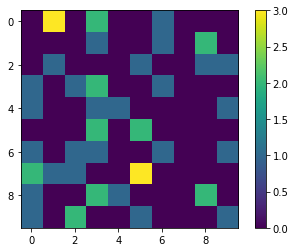

In [6]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

# Opgehaalde data.
De tabel die u hieronder ziet is een overzicht van de opgehaalde data. De data word aan het einde van elke 'step' van de test verzameld, in dit geval 20 steps. Daarom hebben nu, van elke step en elke agent de wealth die ze aan het einde van die step hadden. Met een 'step' bedoel ik de speelronde, als iedereen dus aan de beurd is geweest gaat het naar de volgende 'step'.

In [7]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1
...              ...
20   45            0
     46            2
     47            0
     48            3
     49            2

[1050 rows x 1 columns]

# Visualistatie 2.
Dit laat de Gini-coëfficiënt zien over de loop van de test. De data die we hiervoor gebruiken is uitgelegd in het kopje 'Opgehaalde data.'.

<AxesSubplot:>

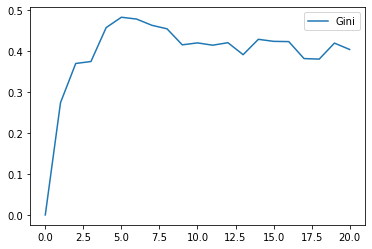

In [8]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

# Visualisatie 3.
Een overzicht van hoevaak een bepaalde hoeveelheid wealth voorkwam per 'step', momenteel dus 'step' 10. Bijvoorbeeld: 1 persoon heeft 5 wealth en 14 mensen hebben 2 wealth. De data die we hiervoor gebruiken is uitgelegd in het kopje 'Opgehaalde data.'.

<AxesSubplot:>

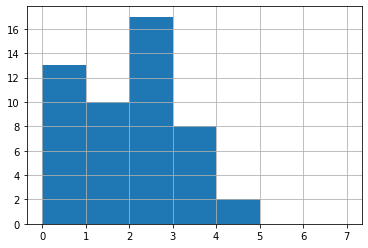

In [9]:
end_wealth = agent_wealth.xs(10, level="Step")["Wealth"]
end_wealth.hist(bins=range(agent_wealth.Wealth.max()+1))

# Visualisatie 4.
Hier wordt een overzicht weergegeven van de wealth van een bepaalde agent, in de loop van de test. In dit geval agent 12. De data die we hiervoor gebruiken is uitgelegd in het kopje 'Opgehaalde data.'.

<AxesSubplot:xlabel='Step'>

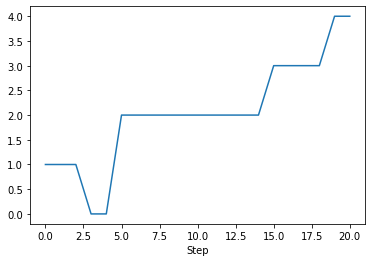

In [10]:
one_agent_wealth = agent_wealth.xs(12, level="AgentID")
one_agent_wealth.Wealth.plot()

# Batch Run. 
Meestal als iemand een model maakt zoals deze, wordt het model niet maar één keer gedraaid maar honderden/duizenden keren. Daarom is Batch run gemaakt, om een model meerdere keren te laten draaien. Er zijn 'fixed_params' dat zijn parameters die altijd hetzelfde blijven, en er zijn 'variable_params' dat zijn parameters die veranderen over de tijd. Zo kunnen de data analysten zien hoe het model reageert op bepaalde aanpassingen op basis van de vergaarde data. De code zal dus wat langer duren om te laden.

In [11]:
fixed_params = {"width": 10,
               "height": 10} # het speelveld blijft hier dus altijd hetzelfde
variable_params = {"N": range(10, 500, 10)} # De hoeveelheid agents varanderd, het begint bij 10 en neemt stappen van tien tot en met 490

batch_run = BatchRunner(MoneyModel,
                        variable_params,
                        fixed_params,
                        iterations=5,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini})
batch_run.run_all()

245it [01:35,  2.58it/s]


# Opgehaalde data 2.
De tabel die u hieronder ziet is een overzicht van de opgehaalde data van de Batch run. N = aantal agents.

In [12]:
run_data = batch_run.get_model_vars_dataframe()
run_data

,N,Run,Gini,width,height
0,10,0,0.409091,10,10
1,10,1,0.491304,10,10
2,10,2,0.355556,10,10
3,10,3,0.447826,10,10
4,10,4,0.330000,10,10
...,...,...,...,...,...
240,490,240,0.403009,10,10
241,490,241,0.399169,10,10
242,490,242,0.385944,10,10
243,490,243,0.397553,10,10


# Visualisatie 5.
Hier ziet u het overzicht van de Gini-coëfficiënt over de loop van alle Runs. De data die we hiervoor gebruiken is uitgelegd in het kopje 'Opgehaalde data 2.'. Uit deze data is te constateren dat met meer mensen de Gini-coëfficiënt minder omhoog en omlaag gaat.

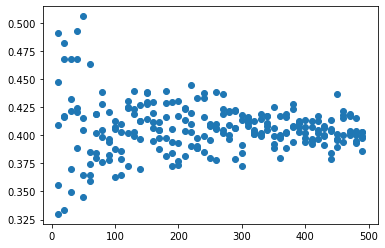

In [13]:
plt.scatter(run_data.N, run_data.Gini)

# GUI. 
Hier wordt de GUI gemaakt waar u de agents kan zien bewegen over het bord. In de functie 'agent_portrayal' wordt meegegeven hoe de agents eruit moeten zien op basis van hoevel wealth ze hebben, ze hebben de agents met een paarse kleur meer dan drie wealth (wealth > 3), men met één of twee wealth rood en mensen zonder wealth zijn grijs. De GUI wordt geopend in een webbrowser, waar te zien zal zijn hoe de agents bewegen, de kleuren zien veranderen en er is een chart te zien die de Gini-coëfficiënt live weergeeft. U kunt zelf instellen met hoeveelstappen per seconde de agents bewegen. Als deze code niet gerund kan worden moet je even een andere server port kiezen. 

In [14]:
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.5}

    if agent.wealth > 0:
        portrayal["Color"] = "red"
        portrayal["Layer"] = 3
        portrayal["r"] = 0.5
    if agent.wealth > 3:
        portrayal["Color"] = "purple"
        portrayal["Layer"] = 2
        portrayal["r"] = 0.75
    if agent.wealth < 1:
        portrayal["Color"] = "grey"
        portrayal["Layer"] = 4
        portrayal["r"] = 0.25
        
    return portrayal

grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)


chart = ChartModule([{"Label": "Gini",
                      "Color": "black"}],
                    data_collector_name='datacollector')

server = ModularServer(MoneyModel,
                       [grid, chart],
                       "Money Model",
                       {"N":100, "width":10, "height":10})
#server.port = 8521 # The default
server.launch()

Interface starting at http://127.0.0.1:8521


OSError: [WinError 10048] Elk socketadres (protocol/netwerkadres/poort) kan normaal slechts één keer worden gebruikt